In [58]:
# Google drive로 Mount

from google.colab import drive
drive.mount('/content/drive/')
# 폴더 이동
%cd '/content/drive/My Drive/hanhwa_AA/Hanhwa_AA/2_Load_forecast/ME-DeepL'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/hanhwa_AA/Hanhwa_AA/2_Load_forecast/ME-DeepL


In [59]:
# 1. Call Libraries
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras import layers
from tensorflow.keras.layers import GRU
from keras.layers import Dropout
from tensorflow.keras.layers import Conv1D, Conv2D, ConvLSTM2D, MaxPool1D
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
import math
import pandas as pd
import scipy.io as sio
from sklearn.metrics import r2_score
from keras.layers import CuDNNGRU, CuDNNLSTM, Activation

In [60]:
# 1. read data
df = pd.read_csv('IMF.csv', delimiter=',')
dataset = df.values
dataset = dataset.T

In [61]:
# 2. Determine length of train set and test set
L = len(dataset)
trainL = math.ceil(L * 4 / 5)
testL = L - trainL
row, col = dataset.shape
col = col - 1

In [62]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back + 1), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [63]:
# 1. Multi-step forecasting approach
for i in range(1):
# 2. Data preparation according to determined length
  look_back = 24 # Window length
  step = i # Prediction step (Maximum step must be equal to mxstep)
  trainX = dataset[:trainL - step, 0:col]
  y_train = dataset[look_back + step:trainL, col]
  x_train, YY = create_dataset(trainX, look_back)
  testX = dataset[trainL:L - step, 0:col]
  y_test = dataset[look_back + trainL + step:L, col]
  x_test, YY = create_dataset(testX, look_back)
  # x_test is converted to 3-dimension data by using moving window
  predictX = dataset[L - step - look_back:L, 0:col]
  x_predict, YY = create_dataset(predictX, look_back)
  print(x_train.shape)
  print(y_train.shape)
  print(x_test.shape)
  print(y_test.shape)

  # Model structure:
  # Input data 1(EMD) -> Encoder: 1D CNN -> RNN(LSTM or GRU) -> Dense
  # Decoder: -> Ensemble -> Forecasting
  size_TimeStep, size_Window, size_EMD = x_train.shape
  Input_data = [x_train[:, :, ii].reshape(size_TimeStep, size_Window, 1) for ii in range(size_EMD)]
  # Input model
  Inputs = [Input(shape=(size_Window, 1), name='IMF_' + str(i)) for i in range(size_EMD)]

  # 2. Branch models
  def branch(input_layer):
    branch_Conv1D = Conv1D(filters=10, kernel_size=7, strides=1, kernel_initializer='random_uniform', padding='same')(input_layer)
    branch_Conv1D = MaxPool1D(pool_size=2, strides=1, padding='same')(branch_Conv1D)
    branch_GRU = GRU(53, return_sequences=True, )(branch_Conv1D)
    branch_GRU = layers.Dropout(0.2)(branch_GRU)
    branch_Dense = (Dense(17, ))(branch_GRU)
    branch_Dense = layers.Dropout(0.1)(branch_Dense)
    # target = (Dense(1))(branch_Dense)

    return branch_Dense

  # concatenate model
  branches = [branch(input) for input in Inputs]

  branches_merge = concatenate(branches)
  Dense_last = Flatten()(branches_merge)
  Dense_last = layers.Dropout(0.01)(Dense_last)

  Dense_last = (Dense(53, ))(Dense_last)
  Dense_last = layers.Dropout(0.1)(Dense_last)
  predictions = (Dense(1, ))(Dense_last)

  Hybrid_model = Model(inputs=Inputs, outputs=predictions)
  # Hybrid_model = multi_gpu_model(Hybrid_model, gpus=2)
  Hybrid_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy', 'mse', 'mae', 'mape'])
  Hybrid_model.summary()

  history = Hybrid_model.fit(Input_data, y_train, epochs=2, batch_size=128) # , validation_split=0.3)
  # Generates output predictions for the input samples.
  trainPredict = Hybrid_model.predict(Input_data)
  size_TimeStep, size_Window, size_EMD = x_test.shape
  Input_Testdata = [x_test[:, :, ii].reshape(size_TimeStep, size_Window, 1) for ii in range(size_EMD)]
  testPredict = Hybrid_model.predict(Input_Testdata)

  # 1. Forecasting results
  trainPredictPlot = np.empty_like(dataset)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[look_back + step:trainL, :] = trainPredict
  testPredictPlot = np.empty_like(dataset)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[look_back + trainL + step:L, :] = testPredict
  # 2. Calculate the forecasting performance
  trainScore = Hybrid_model.evaluate(Input_data, y_train, verbose=0)
  testScore = Hybrid_model.evaluate(Input_Testdata, y_test, verbose=0)
  train_r2 = r2_score(y_train, trainPredict)
  test_r2 = r2_score(y_test, testPredict)
  # 3. Plots the predicted results of the train set and test set
  print('Train Score | R2: %.4f, Acc: %.4f, MSE: %.4f, MAE: %.4f,MAPE: %.4f' % (train_r2, trainScore[0], trainScore[1], trainScore[2], trainScore[3]))
  print('Test Score | R2: %.4f, Acc: %.4f, MSE: %.4f, MAE: %.4f,MAPE: %.4f' % (test_r2, testScore[0], testScore[1], testScore[2], testScore[3]))



(1104, 25, 8)
(1104,)
(257, 25, 8)
(257,)
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 IMF_0 (InputLayer)             [(None, 25, 1)]      0           []                               
                                                                                                  
 IMF_1 (InputLayer)             [(None, 25, 1)]      0           []                               
                                                                                                  
 IMF_2 (InputLayer)             [(None, 25, 1)]      0           []                               
                                                                                                  
 IMF_3 (InputLayer)             [(None, 25, 1)]      0           []                               
                                                  

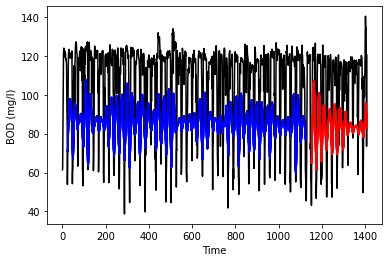

In [64]:
    # Training results Figures 
    
    plt.figure()
    
    plt.plot(dataset[:, col]*100,'k')
    plt.plot(trainPredictPlot*100,'b')
    plt.plot(testPredictPlot*100,'r')
    #plt.plot(PredictPlot,'g')
    plt.xlabel('Time')
    plt.show()

In [55]:
col


7